#Descrição da Atividade

Nesta atividade você vai implementar um sistema de classificação usando os classificadores KNN e SVM. Sua
implementação deve ser feita em Python em um caderno no Jupyter.
Nesta atividade vamos trabalhar com um subconjunto da base de dados MNIST database of handwritten
digits. Este subconjunto da base de dados (disponível no Moodle) contém 1500 imagens em escala de cinza de
tamanho 28x28 (linearizadas em vetores de 784 pixels). As imagens são de dígitos 0-9 manuscritos. O objetivo
do sistema inteligente é classificar cada imagem nas classes que representam os dígitos 0-9. As primeiras
784 colunas da base de dados são os pixels da imagem (valores de 0-255). A ultima coluna representa a
variável de saída, ou seja, o dígito que corresponde à imagem. Existem muitas técnicas para gerar descrições
de imagens que podem ser usadas para representá-las em sistemas de classificação. Entretanto, neste sistema
você deve usar os valores de todos os pixels diretamente para representar as imagens no sistema.
Documente cada um dos passos indicados a seguir no Jupyter:
1. Visualize o espaço formado pelo conjunto de atributos, ou seja, as 784 colunas. Use PCA para reduzir a
dimensionalidade.


2. Avalie o desempenho do classificador KNN usando validação cruzada em um nível, conforme discutimos
em sala. A validação cruzada deve ser em 10 vias. Dica: você deve usar StratifiedKFold para gerar
os particionamentos. Você deve otimizar o hiperparâmetro k, conforme discutimos em sala. Utilize a
métrica acurácia para avaliar o desempenho do classificador. Para avaliar cada particionamento durante
a validação cruzada não se esqueça de normalizar os dados de cada particionamento separadamente.


3. Avalie o desempenho do classificador SVM usando validação cruzada em um nível, conforme discutimos
em sala. A validação cruzada deve ser em 10 vias. Dica: você deve usar StratifiedKFold para gerar
os particionamentos. Você deve otimizar os hiperparâmetros C e γ (gamma), conforme discutimos em
sala. Utilize a métrica acurácia para avaliar o desempenho do classificador. Para avaliar cada particionamento durante a validação cruzada não se esqueça de normalizar os dados de cada particionamento
separadamente.


4. Selecione o classificador que obteve o melhor desempenho usando o teste de hipótese nula baseado no
teste-t. Caso a diferença entre os classificadores não seja significativa, indique que a hipótese nula não
pode ser refutada.

### Dúvidas:

- Plotar o gráfico do knn no svm para vermos com a validação cruzada os melhores gammas;

- Entender melhor o funcionamento do svm (parâmetros e etc).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import seaborn as sns

from utils import do_cv_knn

In [ ]:
df = pd.read_csv("mini_mnist.csv")

# Visualizando os dados utilizando PCA

O PCA significa *Principal Component Analysis* que reduz a dimensionalidade dos dados a fim de facilitar a visualização por parte do programador. Para utilizarmos o mesmo, precisamos da biblioteca PCA do sklearn, evidenciada na próxima linha de código. A redução de dimensionalidade se torna atrativa quando se há muitas colunas para visualização, em outras palavras, ela transforma um ambiente de *n* dimensões em duas dimensões

In [ ]:
#A biblioteca sklearn possui uma implementação de PCA baseado em SVD no modulo decomposition
from sklearn.decomposition import PCA

In [ ]:
y = df['digito']
X = df.drop('digito', axis = 1) # O axis é necessário para para dropar a coluno dígito, já que o padrão é dropar linhas

In [ ]:
pca = PCA(n_components=2)  #instanciando o PCA, indicando o interesse em manter apenas os 2 primeiros componentes principais.
                           #na prática isto quer dizer que queremos projetar os dados para 2 dimensões.

#Estimar os componentes principais
pca.fit(X)

PCA(n_components=2)

In [ ]:
X_pca = pca.transform(X)  # Projetar os 13 atributos nos 2 componentes principais
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])

# Note que a dimensionalidade dos dados projetados agora tem apenas 2 atributos!
print("Instâncias originais: %s\nInstâncias projetadas nos componentes principais: %s" % (str(X.shape), str(X_pca_df.shape)))

Instâncias originais: (1500, 784)
Instâncias projetadas nos componentes principais: (1500, 2)


<Axes: xlabel='PC 0', ylabel='PC 1'>

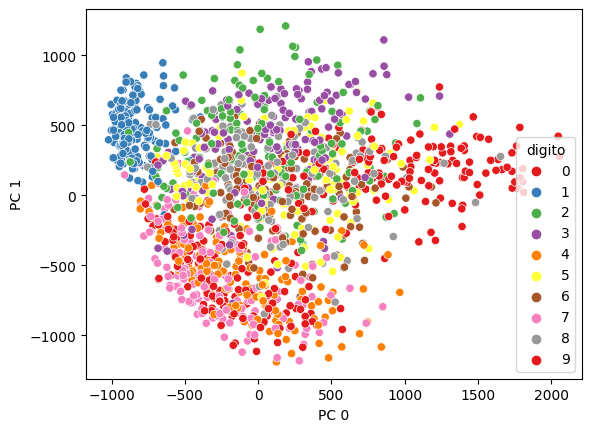

In [ ]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

# Padronização dos dados
## O gráfico acima possui dois problemas principais

1. Os atributos estão em escalas diferentes; 
2. Os atributos não são discriminativos, ou seja, não tem informações suficientes para separar as classes.

Portanto é necessário padronizar os dados já que o knn e o svm consigam funcionar sem problemas, já que por definição eles entendem que os dados já estão padronizados.

### Como padronizar?
Para padronizar os dados, utilizaremos da biblioteca do sk learn StandardScaler, definida abaixo

In [ ]:
from sklearn.preprocessing import StandardScaler

### Invocando a função Standard Scaler para padronizar os dados

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, 
                                       stratify=y, random_state=1)

#Colocar todos os atributos na mesma escala
ss = StandardScaler()
ss.fit(X_treino)
X_treino = ss.transform(X_treino)
X_teste = ss.transform(X_teste)

# Otimizando os Hiperparâmetros

Após normalizar os dados, é necessário normalizar os dados, para isso, precisa-se selecionar o melhor K para o algoritmo KNN.

In [ ]:
acuracias_knn = []
#Testando os Ks ímpares de 1 a 60
ks = list(range(1,60,2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_treino, y_treino)
    pred = knn.predict(X_teste)
    #armazenar a acurácia no conjunto de teste
    acuracias_knn.append(accuracy_score(y_teste, pred))

Melhor k no teste: 3 (acc=0.84)


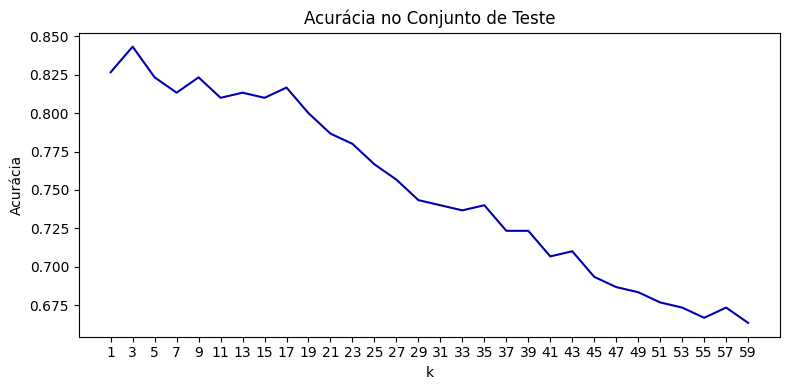

In [ ]:
def plot_knn_k_acc(ks, acuracias_knn, label=''):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(ks, acuracias_knn)
    ax.set_xticks(ks)
    ax.set_xlabel('k')
    ax.set_ylabel('Acurácia')
    ax.set_title('Acurácia no Conjunto de %s' % (label))
    fig.tight_layout()
    plt.show()

melhor_teste = max(acuracias_knn)
melhor_k_teste = ks[np.argmax(acuracias_knn)]
print("Melhor k no teste: %d (acc=%.2f)" % (melhor_k_teste, melhor_teste))

plot_knn_k_acc(ks, acuracias_knn, 'Teste')

### nota-se que o melhor K é 3, com acurácia de 84%. 

# Criando o conjunto de validação

Quando estamos desenvolvendo o algortimo e pretendemos criar a otimização de hiper parâmetros, é de boa prática criar um terceiro conjunto além dos já estudados conjuntos de treino e teste. Este novo conjunto é chamado de conjunto de validação. O nascimento deste novo conjunto se vem pela necessidade de encontrarmos os melhores valores para o novo conjunto de parâmetros que estamos estudando colocar no algoritmo

Para criar o conjunto de validação é necessário:
1. Criar normalmente o conjunto de treino e teste utilizando a biblioteca *train_test_split*;
2. Depois é necessário separar o conjunto de validação através do conjunto de treino

Os passos acima descritos estão evidenciados no código abaixo

In [ ]:
# Execução do passo 1 (separando o conjunto de treino normalmente)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Execução do passo 2 (Dividindo o conjunto de treino em conjunto de validação)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, random_state=1)

ss = StandardScaler()
ss.fit(X_treino)
X_treino = ss.transform(X_treino)
X_teste = ss.transform(X_teste)
X_val = ss.transform(X_val)

#Testando o algoritmo com o novo conjunto de validação especificado

Melhor k na validação: 3 (acc=0.79)


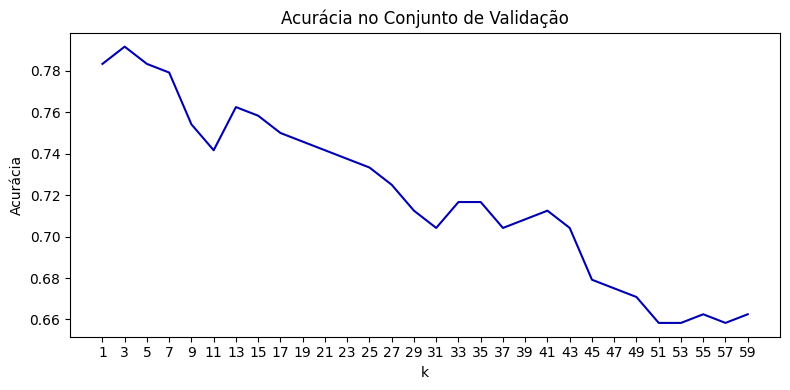

In [ ]:
acuracias_val = []
#Testando os Ks ímpares até o 59
ks = list(range(1,60,2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_treino, y_treino)
    pred = knn.predict(X_val)
    acuracias_val.append(accuracy_score(y_val, pred))

melhor_val = max(acuracias_val)
melhor_k = ks[np.argmax(acuracias_val)]
print("Melhor k na validação: %d (acc=%.2f)" % (melhor_k, melhor_val))
plot_knn_k_acc(ks, acuracias_val, 'Validação')

### Adotando o k = 3 temos a seguinte acurácia:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=melhor_k)
knn.fit(X_treino, y_treino)
pred = knn.predict(X_teste)
print("acurácia no teste: %.2f" % (accuracy_score(y_teste, pred)))

acurácia no teste: 0.81


Agora, criando a função para selecionar o melhor K para então conseguirmos realizar a validação cruzada

In [ ]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val
    

knn, melhor_k, melhor_val = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
print("Melhor k na validação: %d (acc=%.2f)" % (melhor_k, melhor_val))

pred = knn.predict(X_teste)
print("acurácia no teste: %.2f" % (accuracy_score(y_teste, pred)))

Melhor k na validação: 3 (acc=0.79)
acurácia no teste: 0.85


# Utilizando a validação cruzada (*cross validation*)

O pricipal objetivo da validação cruzada é conseguir provar matematicamente a performance de um algoritmo. A ideia da validação cruzada é separar os dados disponíveis em múltiplos dados (*folds*) e repetir isso em x vias. No caso do teste que será realizado, testaremos com 10 vias. O algoritmo basicamente ira repetir os testes com diferentes dados, para assim conseguirmos ter uma noção se o mesmo tem uma boa performance.

Agora que descobrimos o melhor K, podemos utilizar ele para testarmos.

Note que o skf existe para mantermos a proporção dos dados quando as diferentes execuções da validação cruzada forem sendo ativadas.

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, 
                                       stratify=y, random_state=1)
# Número de vias a serem utilizadas
k_vias = 10

# Usada para manter a proporcionalidade entre os dados
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

acuracias_knn = []

for idx_treino, idx_teste in skf.split(X, y):
    
    X_treino = X.iloc[idx_treino]  # Iloc utilizado para conseguirmos manter o algoritmo a par dos dados
    y_treino = y.iloc[idx_treino]
    
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]

    
    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #escolher o k com o melhor resultado no conjunto de validação e treinar o KNN com o melhor k.
    knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias_knn.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias_knn), max(acuracias_knn), np.mean(acuracias_knn), np.std(acuracias_knn)))

min: 0.80, max: 0.89, avg +- std: 0.84+-0.03


# Concluindo a validação cruzada

Pudemos analisar que esse algoritmo possuirá uma taxa de acerto no mundo real de 80 à 89% com uma média de 84%. Os resultados obtidos foram satisfatórios com o Knn. Agora iremos testar o mesmo conjunto de dados com o algoritmo *svm*

# Support Vector Machines (*SVM*)

O algoritmo SVM funciona de maneira extremamente complexa, utilizando de diversos cálculos matemáticos para conseguir calcular parâmetros de decisão. São geralmente úteis em  aplicações que necessitam de um robusto algoritmo de decisão e classificação.

## Utilizando o svm

A biblioteca *sklearn* possui dentro de seu ambiente, uma implementação robusta e confiável do *SVM*, chamada libSVM. A vantagem é que ela nos libera o uso de um *SVM* configurável, assim podendo utilizar dos hiperparâmetros para melhorar o desempenho do algoritmo. Começaremos importando a biblioteca

In [ ]:
from sklearn.svm import SVC
import itertools

# Executando o algoritmo

Agora iremos definir a função selecionar_melhor_svm para podermos extrair a melhor combinação para realizarmos uma validação cruzada e obter o melhor resultado possível em 10 vias. Após a definição da mesma, iremos então treinar o svm com o conjunto de dados.

In [ ]:
def selecionar_melhor_svm(Cs, gammas, X_treino : np.ndarray, X_val : np.ndarray, 
                          y_treino : np.ndarray, y_val : np.ndarray, n_jobs=4):
    
    def treinar_svm(C, gamma, X_treino, X_val, y_treino, y_val):
        svm = SVC(C=C, gamma=gamma)
        svm.fit(X_treino, y_treino)
        pred = svm.predict(X_val)
        return accuracy_score(y_val, pred)
    
    #gera todas as combinações de parametros C e gamma, de acordo com as listas de valores recebidas por parametro.
    #Na prática faz o produto cartesiano entre Cs e gammas.
    combinacoes_parametros = list(itertools.product(Cs, gammas))
    
    #Treinar modelos com todas as combinações de C e gamma
    acuracias_val = Parallel(n_jobs=n_jobs)(delayed(treinar_svm)
                                       (c, g, X_treino, X_val, y_treino, y_val) for c, g in combinacoes_parametros)       
    
    melhor_val = max(acuracias_val)
    #Encontrar a combinação que levou ao melhor resultado no conjunto de validação
    melhor_comb = combinacoes_parametros[np.argmax(acuracias_val)]   
    melhor_c = melhor_comb[0]
    melhor_gamma = melhor_comb[1]
    
    #Treinar uma SVM com todos os dados de treino e validação usando a melhor combinação de C e gamma.
    svm = SVC(C=melhor_c, gamma=melhor_gamma)
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_comb, melhor_val


# Realizando a validação cruzada
Após criarmos a função que nos retorna a melhor combinação para utilizarmos como um hiperparâmetro, agora nos resta realizar a validação cruzada, evidenciada pelo código abaixo.

In [ ]:
#Implementa a validação cruzada para avaliar o desempenho da SVM na base de dados com as instâncias X e as saídas y.
#cv_splits indica o número de partições que devem ser criadas.
#Cs é a lista com os valores C que devem ser avaliados na busca exaustiva de parametros para a SVM.
#gammas s é a lista com os valores gamma que devem ser avaliados na busca exaustiva de parametros para a SVM.
def do_cv_svm(X, y, cv_splits, Cs=[1], gammas=['scale']):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        svm, _, _ = selecionar_melhor_svm(Cs, gammas, X_treino, X_val, y_treino, y_val)
        pred = svm.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        pgb.update(1)
              
    pgb.close()
    
    return acuracias

In [ ]:
accs_svm = do_cv_svm(X.values, y, 10, Cs=[1, 10, 100, 1000], gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4])

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

###Adicionando as funções para cálculo das estatísticas
Note que no código do svm não foi preciso o uso do *iloc* já que estamos trabalhando com uma numpy array e não um panda dataframe.

In [ ]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

imprimir_estatisticas(accs_svm)

Resultados: 0.88 +- 0.02, min: 0.84, max: 0.91


### Observações sobre o SVM e utilizando o teste T
A primeira coisa que é possível notar sobre o *SVM* é que ele é um algoritmo computacionalmente complexo, ou seja, seu tempo de execução é evidentemente muito maior que o seu contrário KNN. A segunda observação é que ele obteve um índice de acerto um pouco melhor que o KNN, porém o custo foi uma elevada taxa de processamento. Agora nos resta descobrir se esse custo é realmente melhor levando em conta o desvio padrão e as médias. Para isso utilizaremos de uma hipótese chamada de teste t. O teste t faz comparações entre as médias para nos dizer se a diferença entre elas realmente é algo tangível, ou seja, se há realmente uma diferença significativa entre as médias.

No caso abaixo iremos testar as médias do Knn e do svm, para vermos se realmente há diferença entre os resultados de ambos.

In [ ]:
from scipy.stats import ttest_ind_from_stats

In [ ]:
#Primeiramente calculamos a média e o desvio padrão dos resultados
media_knn, std_knn, _, _ = calcular_estatisticas(acuracias_knn)
media_svm, std_svm, _, _ = calcular_estatisticas(accs_svm)

#calcular o pvalor usando o teste t de Student para duas amostras independentes
_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(acuracias_knn), media_svm, std_svm, len(accs_svm))

In [ ]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [ ]:
rejeitar_hip_nula(media_knn, std_knn, len(acuracias_knn), media_svm, std_svm, len(accs_svm))

True

# Conclusão
Note que a saída foi verdadeira, logo, levando em conta as médias e desvios padrões entre os algoritmos, o SVM realmente se mostrou com uma performance maior do que o Knn para o conjunto de dados.